# Creating a source model from PVGIS

In this notebook we go through the steps of creating an LSTM model that has been trained on synthetic data which we fetch from PVGIS through their API.

## 1. Fetching data from PVGIS

In [1]:
# Import the datafetcher class
from src.data.datafetcher import PvFetcher

# Set parameters
latitude = 50.6
longitude = 2.34
peakPower = 2.4
tilt = 33
azimuth = 0

# Fetch data from PVGIS
data = PvFetcher(latitude,longitude,peakPower,tilt,azimuth)

# Save the data in the data folder
path = data.save_data()
path

Gathering data from base location...


'dataset_240628_1150.pkl'

In [2]:
# Show some of the data
data.dataset[0].head()

,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
time,,,,,,,,
2005-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,7.47,2.21,0
2005-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,7.00,2.28,0
2005-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,6.89,2.07,0
2005-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,6.69,2.00,0
2005-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,6.53,2.21,0


In [3]:
# Import the weather datafetcher class
from src.data.datafetcher import WeatherFetcher

# Specify the parameters of interest
weather_vars = ['diffuse_radiation', 'direct_radiation', 'temperature_2m', 'cloud_cover']

# Fetch the data from Open Meteo
weather_data = WeatherFetcher(data.location_list, weather_vars)

Coordinates 50.57996368408203°N 2.389380693435669°E
Elevation 59.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


## 2. Preparing the data for use in the model

In [4]:
weather_data.weather_dataset[0]

,diffuse_radiation,direct_radiation,temperature_2m,cloud_cover
date,,,,
2005-01-01 00:00:00,0.0,0.0,7.4255,46.799999
2005-01-01 01:00:00,0.0,0.0,6.9255,60.299999
2005-01-01 02:00:00,0.0,0.0,6.7755,55.499996
2005-01-01 03:00:00,0.0,0.0,6.5755,74.099998
2005-01-01 04:00:00,0.0,0.0,6.3755,72.000000
...,...,...,...,...
2020-12-31 19:00:00,0.0,0.0,0.8085,71.099998
2020-12-31 20:00:00,0.0,0.0,0.6585,47.099998
2020-12-31 21:00:00,0.0,0.0,0.0585,43.200001


In [9]:
import pandas as pd

dataset = pd.merge(data.dataset[0][['P']], weather_data.weather_dataset[0], left_index=True, right_index=True)

### 2.1 Selecting and adding features

In [10]:
# Import the featurisation class
from src.data.featurisation import Featurisation

# Decide on the features to use in making the model (Note that 'P' should always be included since it's the target variable)
dataset = Featurisation(dataset).base_features(['P'] + weather_vars)

# Use daily cyclic features as well
dataset = Featurisation(dataset).cyclic_features()

In [12]:
dataset[0] = dataset[0].rename(columns={'P': 'PV_power'})

In [14]:
dataset = dataset[0]

In [13]:
# Show the featurized dataset
dataset[0].head()

,PV_power,diffuse_radiation,direct_radiation,temperature_2m,cloud_cover,hour_sin,hour_cos,month_sin,month_cos
time,,,,,,,,,
2005-01-01 00:00:00,0.0,0.0,0.0,7.4255,46.799999,0.000000,1.000000,0.5,0.866025
2005-01-01 01:00:00,0.0,0.0,0.0,6.9255,60.299999,0.258819,0.965926,0.5,0.866025
2005-01-01 02:00:00,0.0,0.0,0.0,6.7755,55.499996,0.500000,0.866025,0.5,0.866025
2005-01-01 03:00:00,0.0,0.0,0.0,6.5755,74.099998,0.707107,0.707107,0.5,0.866025
2005-01-01 04:00:00,0.0,0.0,0.0,6.3755,72.000000,0.866025,0.500000,0.5,0.866025


### 2.2 Transforming the dataframe to tensors

In [17]:
from src.tensors.tensorisation import Tensors
import torch

src_tensors = Tensors(dataset, 'PV_power', past_features=['PV_power'] , future_features=weather_vars, 
                      lags=24, forecast_period=24, gap=0, forecast_gap=0)

X_train, X_test, y_train, y_test = src_tensors.create_tensor()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4674, 24, 5]),
 torch.Size([1169, 24, 5]),
 torch.Size([4674, 24]),
 torch.Size([1169, 24]))

## 3. Creating and training the model

In [18]:
# Import the lstm class to create an untrained LSTM
from src.models.lstm import LSTM

# Set the parameters for the lstm
input_size = len(['PV_power'] + weather_vars)
hidden_size = 100
num_layers = 3
dropout = 0.3
forecast_period = 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_lstm = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
my_lstm

LSTM(
  (lstm): LSTM(5, 100, num_layers=3, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=24, bias=True)
)

Step 0: Average train loss: 0.0180 | Average test loss: 0.0101
Step 5: Average train loss: 0.0101 | Average test loss: 0.0081
Step 10: Average train loss: 0.0095 | Average test loss: 0.0076
Step 15: Average train loss: 0.0093 | Average test loss: 0.0072
Step 20: Average train loss: 0.0091 | Average test loss: 0.0071
Step 25: Average train loss: 0.0089 | Average test loss: 0.0070
Step 30: Average train loss: 0.0088 | Average test loss: 0.0070
Step 35: Average train loss: 0.0087 | Average test loss: 0.0069
Step 40: Average train loss: 0.0086 | Average test loss: 0.0069
Step 45: Average train loss: 0.0085 | Average test loss: 0.0071
Step 50: Average train loss: 0.0085 | Average test loss: 0.0070
Step 55: Average train loss: 0.0084 | Average test loss: 0.0072
Step 60: Average train loss: 0.0083 | Average test loss: 0.0073
Step 65: Average train loss: 0.0082 | Average test loss: 0.0075
Step 70: Average train loss: 0.0081 | Average test loss: 0.0075
Step 75: Average train loss: 0.0079 | Aver

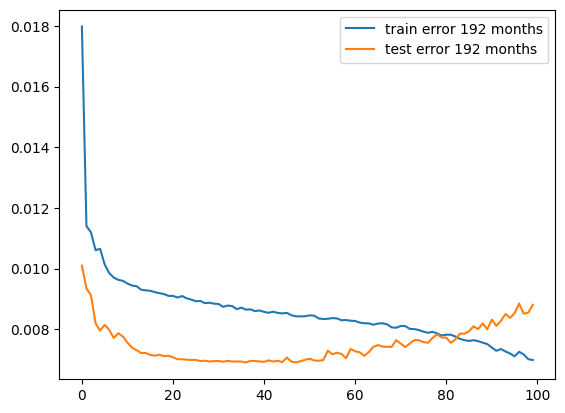

In [19]:
# Import the training class to train the model
from src.models.training import Training

# Set the training parameters
epochs = 100

# Initialize the trainer
training = Training(my_lstm, X_train, y_train, X_test, y_test, epochs)

# Train the model and return the trained parameters and the best iteration
state_dict_list, best_epoch = training.fit()

In [20]:
# Load the state dictionary of the best performing model

my_lstm.load_state_dict(state_dict_list[best_epoch])

<All keys matched successfully>

In [21]:
# Save the model state dictionary for later use
from src.models.training import save_model

save_model(my_lstm, 'example_model')

## 4. Inference and evaluation

In [22]:
# Forecast with the model
forecasts = my_lstm(X_test.to(device))

In [26]:
# Import the evaluation script
from src.evaluation.evaluation import Evaluation

# Evaluate the model performance
evaluate = Evaluation(y_test, forecasts)

# Show the evaluation metrics
evaluate.metrics()

,RMSE,Var(x),Var(y),Corr,Bias,Conditional bias 1,Resolution,Conditional bias 2,Discrimination
Metrics,0.094,0.056,0.053,0.920,0.000,0.009,0.056,0.008,0.056


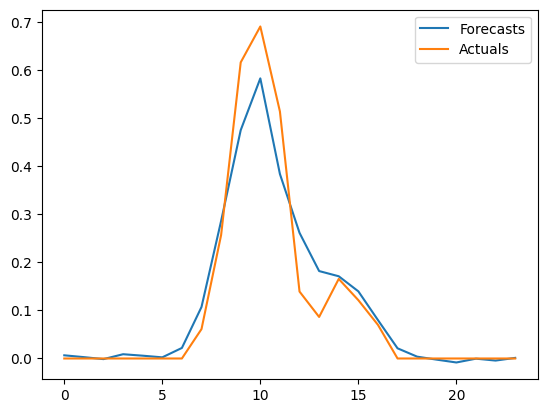

In [29]:
# Plot some of the forecasts
import matplotlib.pyplot as plt

plt.plot(forecasts[2].cpu().detach().numpy(), label="Forecasts")
plt.plot(y_test[2], label="Actuals")

plt.legend()
plt.show()